# **Assignment \#4**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2022s2

In [1]:
# TODO: RA & Name 
print('RA1: ' + 'Full_Name_1')
print('RA2: ' + 'Full_Name_2')

RA1: Full_Name_1
RA2: Full_Name_2


## Objective

Exploring **unsupervised learning techniques** by using dimensionality reduction techniques.

## Import Libraries

In [2]:
# Libraries are free to use! You can use Scikit-learn, Keras/TensorFlow, PyTorch, ... 
import torch
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from tqdm import tqdm

In [3]:
#Setting a SEED for data reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

Fashion-MNIST is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

Dataset Information:

- You should respect the following traininig/test split: 60,000 training examples, and 10,000 test examples. Avoid overfitting.

- The data is available at:
https://www.dropbox.com/s/qawunrav8ri0sp4/fashion-mnist-dataset.zip:
‘train’ folder (fashion-mnist train.csv.zip) + ‘test’ folder (fashion-mnist test.csv.zip).

  - You can also download the data by the framework you are using.

- Each training and test example is assigned to one of the following labels: 0 t-shirt/top, 1 trouser, 2 pullover, 3 dress, 4 coat, 5 sandal, 6 shirt, 7 sneaker, 8 bag, 9 ankle boot.
- Each row is a separate image. Column 1 is the class label. The remaining columns are pixel numbers (784 total). Each value is the darkness of the pixel (1 to 255). Dataset was converted to CSV with this script: https://pjreddie.com/projects/mnist-in-csv.

In [4]:
# Download Fashion-MNIST
#->
df = pd.read_csv("../input/fashion-mnist/fashion-mnist_train.csv")
df.iloc[:, 1:] = df.iloc[:, 1:] /255
df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,9,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


### Data Exploration:

In [5]:
#checking labels destribution
df['label'].value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

In [6]:
#Checking if all pixels are between 0 and 255:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,4.500000,0.000004,0.000024,0.000139,0.000400,0.000972,0.001614,0.003160,0.008621,0.022282,...,0.135786,0.091375,0.065052,0.070076,0.089470,0.070241,0.033414,0.010797,0.003355,0.000275
std,2.872305,0.000371,0.001063,0.004793,0.009619,0.016890,0.022887,0.032216,0.055268,0.093410,...,0.225668,0.191586,0.164626,0.172416,0.203257,0.177056,0.116137,0.068226,0.036694,0.008337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.227451,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,0.062745,0.141176,0.886275,0.643137,0.890196,0.901961,0.878431,1.000000,0.996078,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667


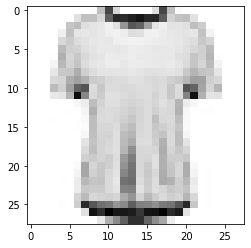

In [7]:
img =  plt.imshow(df.iloc[:,1:].iloc[1500].values.reshape(28,28),cmap='Greys')

### Activities

1. (2 points) Baseline: Explore Convolutional Neural Networks with Fashion-MNIST. What is the accuracy of your CNN model? (1.5 points) Describe your Convolutional Neural Network architecture. (0.5 points) What are your conclusions about the baseline?

In [8]:
##############################################################################################################
#####                                        utils functions
##############################################################################################################

def save_metric_plot(train_metric, val_metric):
    '''
    Create a graph Comparing the validation and train Loss x Epochs
        Args:
            train_metric: list with train metric values
            val_metric: list with val metric values
        Retuns:
            loss.jpg figure 
    '''
    plt.figure(figsize=(10,7))
    plt.plot(train_metric, color='blue', label='train loss')
    plt.plot(val_metric, color='red', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.jpg')
    plt.show()
    

def train_val_split(df, train_frac=0.80, val_frac=0.20):
    '''
    Performs train val split of the dataframe
    Args:
        df: input dataframe
        train_frac: train fraction
        val_frac: validation fraction
    Returns:
        train_df: Train dataset
        val_df: Validation dataset
    '''

    # shuffle the dataset
    df = df.sample(frac=1).reset_index(drop=True)
    #train val split the data
    num_train_samples = math.floor(len(df) * train_frac)
    num_val_samples = math.floor(len(df) * val_frac)

    train_df = df[:num_train_samples].reset_index(drop=True)
    val_df = df[-num_val_samples:].reset_index(drop=True)

    return train_df, val_df


def create_new_df(original_df, reduction_result):
    '''
    Create new dataframe based on the dimensionality reduction technique output
    Args:
        original_df: original dataframe
        reduction_result: dimensionality reduction output
    Returns:
        new_df: new df output
    '''
    new_df = original_df.iloc[:, :1].copy()
    new_df[[f"pixel{i}" for i in range(1, reduction_result.shape[1] + 1)]] = reduction_result
    
    return new_df
    
    
def retrain_model(new_df, size):
    """
    Retrain the base model based on the new dataframe
    Args:
        new_df : resulted data frame from PCA or Autoencoder
        size: image size
    """

    train_pca_df, val_pca_df = train_val_split(new_df)
    train_set_pca = FashionMinistDataset(train_pca_df,img_size=size, is_train=True)
    val_set_pca = FashionMinistDataset(val_pca_df,img_size=size, is_train=False)

    #Setting DataLoaders:
    train_loader_pca = DataLoader(train_set_pca, shuffle=True, batch_size=64)
    val_loader_pca = DataLoader(val_set_pca, shuffle=False, batch_size=64)

    model = ConvNetwork()
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    print('Model Architecture')
    print(model)

    train_loss_pca, val_loss_pca, train_metric_pca, val_metric_pca,saved_path = train_network(10, train_loader_pca, val_loader_pca, model, optimizer, criterion, accuracy_score)


In [9]:
#Spliting the data in train and validation steps:

train_df, val_df = train_val_split(df)
print(f'Len df Train: {len(train_df)}, Len df Val: {len(val_df)}')
# print(f'Len X Train: {len(x_train)}, Len X Val: {len(x_val)}, Len y Train: {len(y_train)}, Len X Val: {len(y_val)} ')

Len df Train: 48000, Len df Val: 12000


In [10]:
#DatasetCLass:
class FashionMinistDataset(Dataset):
       
    def __init__(self, df, img_size=28, is_train=True):
        self.data = list(df.values)
        self.is_train = is_train

        img = []
        label = []

        for i in self.data:
            img.append(i[1:])
            label.append(i[0])

        self.imgs = (np.asarray(img).reshape(-1, img_size, img_size, 1)).astype('float32')  
        self.list_labels = np.asarray(label)
      
        if self.is_train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.RandomVerticalFlip(p=0.3),
                transforms.ToTensor()
            ])
        else: 
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        img = self.imgs[index]
        img = self.transform(img)
        label = torch.tensor(self.list_labels[index]).long()
#         print(type(img), type(label))
 

        return img, label

    

In [11]:
#Setting Dataset:
train_set = FashionMinistDataset(train_df, is_train=True)
val_set = FashionMinistDataset(val_df, is_train=False)

#Setting DataLoaders:
train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
val_loader = DataLoader(val_set, shuffle=False, batch_size=64)

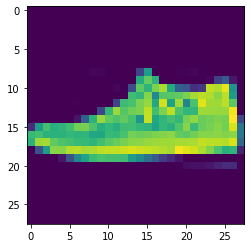

In [12]:
#Checking image and label after dataset pipeline
plt.imshow(train_set[6000][0][0].numpy())

In [13]:
# Create your convolutional neural network architecture

class ConvNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        #Conv1Layer1 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, padding=3),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
#             nn.AvgPool2d(kernel_size=2, stride=2)
        )
        #Conv1Layer2 
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        #Conv1Layer3 
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.drop = nn.Dropout(0.1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_features=128, out_features=10)
        
       
    def forward(self, x):
              
        #Conv1Layer1                      
        output = self.layer1(x)
        #Conv1Layer2
        output = self.layer2(output)
        #Conv1Layer3
        output = self.layer3(output)
        #Reshape --> flatten
        output = self.pool(output)
        output = output.view(output.size(0), -1)
        #dropout
        output = self.drop(output)
        #FullyConnected 1
        output = self.fc1(output)        
        return {"logit": output, "pred": self.postprocess(output)}
    
    def postprocess(self, prob):
        return prob.argmax(dim=1, keepdim=True)

In [14]:
# Train loop

def train_step(model, train_loader, optimizer, criterion, device, metric_fn, epoch, autoencoder=False):
    criterion = criterion.to(device)
    model.train()
    train_running_loss = 0.0
    train_running_metric = 0.0
    pbar = tqdm(train_loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        
        target = target.to(device)
        #Clean Gradients
        optimizer.zero_grad()
        
        output = model(img)
        logit = output["logit"]
        pred = output["pred"]
        
        loss = criterion(logit, target)
        
        if autoencoder:
            metric = metric_fn(target, pred)
        else:
            metric = metric_fn(target.to('cpu').numpy(), pred.to('cpu').numpy())
        
        #Perform Backpropagation
        loss.backward()
        # Setp in the optimizer
        optimizer.step()
        
        train_running_loss += loss.item()
        train_running_metric += metric.item()
        pbar.set_postfix_str(f"Train: Epoch:{epoch}, Loss:{loss.item():.3f}, Metric:{metric.item():.3f}")
    train_loss = train_running_loss / (len(train_loader) + 1)
    train_metric = train_running_metric / (len(train_loader) + 1)
        
    return train_loss, train_metric
        
        
@torch.no_grad()       
def validate_step(model, val_loader, criterion, device, metric_fn, epoch, autoencoder=False):
    criterion = criterion.to(device)
    
    model.eval()
    val_running_loss = 0.0
    val_running_metric = 0.0
    pbar = tqdm(val_loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        target = target.to(device)
        
        
        output = model(img)
        logit = output["logit"]
        pred = output["pred"]
        
        loss = criterion(logit, target)
        if autoencoder:
            #Model Performance
            val_metric = metric_fn(target, pred)
        else:
            val_metric = metric_fn(target.to('cpu').numpy(), pred.to('cpu').numpy())
        
        
        val_running_loss += loss.item()
        val_running_metric += val_metric.item()
        pbar.set_postfix_str(f"Val: Epoch:{epoch}, Loss:{loss.item():.3f}, Metric: {val_metric.item():.3f}")
    val_loss = val_running_loss / (len(val_loader) + 1)
    val_metric = val_running_metric / (len(val_loader) + 1)
        
    return val_loss, val_metric

@torch.no_grad()       
def test_step(model, test_loader, device, metric_fn):
    model.eval()
    test_running_metric = 0.0
    pbar = tqdm(test_loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        target = target.to(device)
        
        
        output = model(img)
        logit = output["logit"]
        pred = output["pred"]
        
        loss = criterion(logit, target)
        test_metric = metric_fn(target.to('cpu').numpy(), pred.to('cpu').numpy())
        test_running_metric += test_metric.item()
        
    test_metric = test_running_metric / (len(test_loader) + 1)
    print(f'Test Accuracy:{test_metric}')
        
    return test_metric
        
    
def train_network(nb_epochs, train_loader, val_loader, model, optimizer, criterion, metric_fc, autoencoder=False):
    train_loss = []
    val_loss = []
    train_metric = []
    val_metric = []
    best_metric = np.inf if autoencoder else 0
    last_save_path = ""

    for epoch in range(nb_epochs):
#         print(f"Epoch {epoch+1} of {EPOCHS}")
        train_epoch_loss, train_epoch_metric = train_step(
            model, train_loader, optimizer, criterion, device, metric_fc, epoch, autoencoder=autoencoder
        )
        val_epoch_loss, val_epoch_metric = validate_step(
            model, val_loader, criterion, device, metric_fc,epoch,autoencoder=autoencoder
        )
            
        #Saving Model
        improved = val_epoch_metric >= best_metric
        if autoencoder:
            improved = not improved
            
        if improved:
            best_metric = val_epoch_metric
            new_path = os.path.join('.', f"best_model_epoch_{epoch+1}_metric_{best_metric:.3f}.ckpt")
            print(f'Saving Model {new_path}')
            torch.save(model.state_dict(), new_path) 
            if os.path.exists(last_save_path):
                os.remove(last_save_path)
            last_save_path = new_path
            
        train_loss.append(train_epoch_loss)
        val_loss.append(val_epoch_loss)
        train_metric.append(train_epoch_metric)
        val_metric.append(val_epoch_metric)
        
    return train_loss, val_loss, train_metric, val_metric, last_save_path

    

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ConvNetwork()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('Model Architecture')
print(model)

train_loss, val_loss, train_metric, val_metric, conv_last_save_path = train_network(20, train_loader, val_loader, model, optimizer, criterion, accuracy_score)

Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 100.16it/s, Val: Epoch:0, Loss:1.017, Metric: 0.688]


Saving Model ./best_model_epoch_1_metric_0.708.ckpt


100%|██████████| 188/188 [00:01<00:00, 103.20it/s, Val: Epoch:1, Loss:0.716, Metric: 0.750]


Saving Model ./best_model_epoch_2_metric_0.732.ckpt


100%|██████████| 188/188 [00:01<00:00, 102.47it/s, Val: Epoch:2, Loss:0.589, Metric: 0.750]


Saving Model ./best_model_epoch_3_metric_0.809.ckpt


100%|██████████| 188/188 [00:02<00:00, 87.16it/s, Val: Epoch:3, Loss:0.517, Metric: 0.844]


Saving Model ./best_model_epoch_4_metric_0.849.ckpt


100%|██████████| 188/188 [00:01<00:00, 101.03it/s, Val: Epoch:5, Loss:0.551, Metric: 0.812]


Saving Model ./best_model_epoch_6_metric_0.852.ckpt


100%|██████████| 188/188 [00:01<00:00, 94.05it/s, Val: Epoch:7, Loss:0.418, Metric: 0.750] 


Saving Model ./best_model_epoch_8_metric_0.864.ckpt


100%|██████████| 188/188 [00:01<00:00, 103.59it/s, Val: Epoch:9, Loss:0.407, Metric: 0.875]


Saving Model ./best_model_epoch_10_metric_0.875.ckpt


100%|██████████| 188/188 [00:01<00:00, 102.88it/s, Val: Epoch:14, Loss:0.455, Metric: 0.844]


Saving Model ./best_model_epoch_15_metric_0.880.ckpt


100%|██████████| 188/188 [00:02<00:00, 91.10it/s, Val: Epoch:18, Loss:0.328, Metric: 0.844]


Saving Model ./best_model_epoch_19_metric_0.891.ckpt


100%|██████████| 188/188 [00:01<00:00, 102.07it/s, Val: Epoch:19, Loss:0.635, Metric: 0.781]


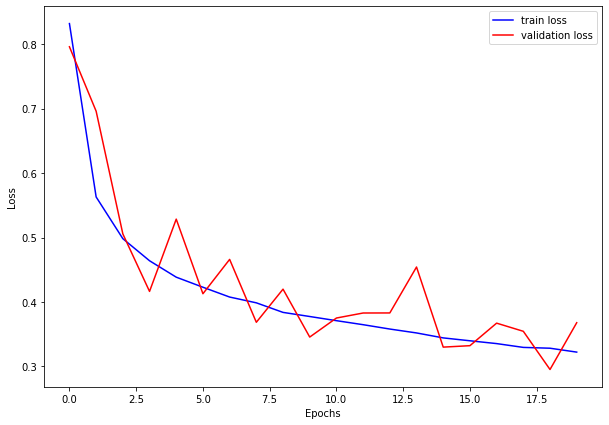

In [16]:
save_metric_plot(train_loss, val_loss)

In [17]:
# Report your accuracy using convolutional neural network
# Testing the neural net in the test data:

df_test = pd.read_csv("../input/test-mnist/fashion-mnist_test.csv")
df_test.iloc[:, 1:] = df_test.iloc[:, 1:] /255
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.035294,0.031373,...,0.403922,0.341176,0.219608,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.133333,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.054902,0.207843,0.388235,...,0.000000,0.000000,0.000000,0.0,0.247059,0.207843,0.121569,0.000000,0.0,0.0
3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.537255,0.494118,0.549020,0.0,0.521569,0.878431,0.870588,0.219608,0.0,0.0
4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [18]:
test_set = FashionMinistDataset(df_test, is_train=False)

#Setting DataLoaders:
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

#Loading the model:
model = model.to(device)
model.load_state_dict(torch.load(conv_last_save_path))

test_metric = test_step(model, test_loader,device, accuracy_score)


100%|██████████| 157/157 [00:01<00:00, 136.29it/s]

Test Accuracy:0.8930973101265823


In [19]:
# What are your conclusions about the baseline? 

2. (2 points) Using PCA: Re-do the first experiment considering the PCA dimensionality reduction. (1.5 points) Consider two different energies (variance) for reducing the image dimensionality. (0.5 points) What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [20]:
# Run PCA methods
features_df = df.drop(['label'], axis=1)
features_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [21]:
def calculate_variance(components, original_df, df_features):
    pca = PCA(n_components=components)
    pca_output = pca.fit_transform(df_features)
    variance = sum(pca.explained_variance_ratio_)
    print(f'Num. of PCA componentes {components} and variance {variance}')
    return pca_output



In [22]:
#First PCA: New image size: 22 x 22
pca_484 = calculate_variance(484,df,features_df)
df_pca_484 = create_new_df(df, pca_484)

#Second PCA: New image size: 18 x 18
pca_256 = calculate_variance(256,df,features_df)
df_pca_256 = create_new_df(df, pca_256)


Num. of PCA componentes 484 and variance 0.9914870125313527


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Num. of PCA componentes 256 and variance 0.965838357229293


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [23]:
# Re-do the first experiment considering the PCA dimensionality reduction
#train
model_trained_with_pca_484 = retrain_model(df_pca_484, 22)

model_trained_with_pca_256 = retrain_model(df_pca_256, 16)



Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 102.95it/s, Val: Epoch:0, Loss:0.654, Metric: 0.719]


Saving Model ./best_model_epoch_1_metric_0.726.ckpt


100%|██████████| 188/188 [00:01<00:00, 106.30it/s, Val: Epoch:2, Loss:0.364, Metric: 0.875]


Saving Model ./best_model_epoch_3_metric_0.776.ckpt


100%|██████████| 188/188 [00:01<00:00, 104.92it/s, Val: Epoch:4, Loss:0.312, Metric: 0.875]


Saving Model ./best_model_epoch_5_metric_0.817.ckpt


100%|██████████| 188/188 [00:01<00:00, 105.61it/s, Val: Epoch:7, Loss:0.308, Metric: 0.906]


Saving Model ./best_model_epoch_8_metric_0.823.ckpt


100%|██████████| 188/188 [00:01<00:00, 109.85it/s, Val: Epoch:9, Loss:0.238, Metric: 0.906]


Saving Model ./best_model_epoch_10_metric_0.836.ckpt
Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 107.73it/s, Val: Epoch:0, Loss:1.420, Metric: 0.438]


Saving Model ./best_model_epoch_1_metric_0.454.ckpt


100%|██████████| 188/188 [00:01<00:00, 105.40it/s, Val: Epoch:1, Loss:0.678, Metric: 0.781]


Saving Model ./best_model_epoch_2_metric_0.765.ckpt


100%|██████████| 188/188 [00:01<00:00, 109.06it/s, Val: Epoch:2, Loss:0.561, Metric: 0.844]


Saving Model ./best_model_epoch_3_metric_0.806.ckpt


100%|██████████| 188/188 [00:01<00:00, 110.34it/s, Val: Epoch:4, Loss:0.352, Metric: 0.906]


Saving Model ./best_model_epoch_5_metric_0.807.ckpt


100%|██████████| 188/188 [00:01<00:00, 108.45it/s, Val: Epoch:8, Loss:0.468, Metric: 0.812]


Saving Model ./best_model_epoch_9_metric_0.815.ckpt


100%|██████████| 188/188 [00:01<00:00, 111.13it/s, Val: Epoch:9, Loss:0.376, Metric: 0.875]


Saving Model ./best_model_epoch_10_metric_0.845.ckpt


3. (0.5 point) What can we infer when analyzing the breakdown of data into components using a chart to plot the data in 2-dimensional space to view separation?

In [24]:
# In order to see how the PCA components are separating out the digits, lets use the following method, plot_components, to plot the data in a 2 dimensional space to view separation.
# The input parameters are the PCA fit in X and the labels
# def plot_components(X, y):
#     x_min, x_max = np.min(X, 0), np.max(X, 0)
#     X = (X - x_min) / (x_max - x_min)
#     plt.figure(figsize=(10, 6))
#     for i in range(X.shape[0]):
#         plt.text(X[i, 0], X[i, 1], str(y[i]), 
#                  color=plt.cm.Set1(y[i]), 
#                  fontdict={'size': 15})

#     plt.xticks([]), plt.yticks([]), plt.ylim([-0.1,1.1]), plt.xlim([-0.1,1.1])

In [25]:
# The input parameters are the PCA fit in X and the labels
# plot_components(#?, #?)

4. (2 points) How many components are needed for a better evaluation of the model? Define the minimum and maximum components to be tested using the energies_number method. How can we evaluate this graph and the quantity that was defined as best for the problem?

In [26]:
# Iteratively check how many principal components would be required in order to reach a reasonable accuracy with the same random neural network.

# def energies_number(min, max, X):
#     # Select a range of min and max number of dimensions, min/max.

#     acc_list, pc_list = [], []
#     for pc in range(min,max):
#         pca = # Run the PCA algorithm for dimensionality reduction.
#         acc = # C}alculate the accuracy of the neural network using the reduced dimension by PCA
#         acc_list.append(acc)
#         pc_list.append(pc)
#     return acc_list, pc_list

# acc_list, pc_list = energies_number( #?, #? , #? )

In [27]:
# plt.figure(figsize=[12,9])
# plt.scatter(pc_list, acc_list)
# plt.title('Neural Network Plot Accuarcy as a Function of Number of Principal Components')
# plt.xlabel('Principal Components')
# plt.ylabel('Accuracy');

In [28]:
# print('The maximum accuracy attained is ',np.max(acc_list),'% with ',pc_list[np.where(acc_list == np.max(acc_list))[0][0]],' principal components. Beyond this peak, additional principal components appear to mostly contribute noise.')

5. (3.5 points) Using Autoencoders: Re-do the first experiment (question 2) considering Autoencoders for reducing the image dimensionality. (3 points) Consider two different latent vector sizes for reducing the image dimensionality. (0.5 points) What are the conclusions when using Autoencoders in this problem? Does accuracy improve? 

Autoencoders are a branch of neural networks which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over some iterations using gradient descent, minimizing the mean squared error.
The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can be treated as a variable in the same way each chosen principal component is used in the following models.

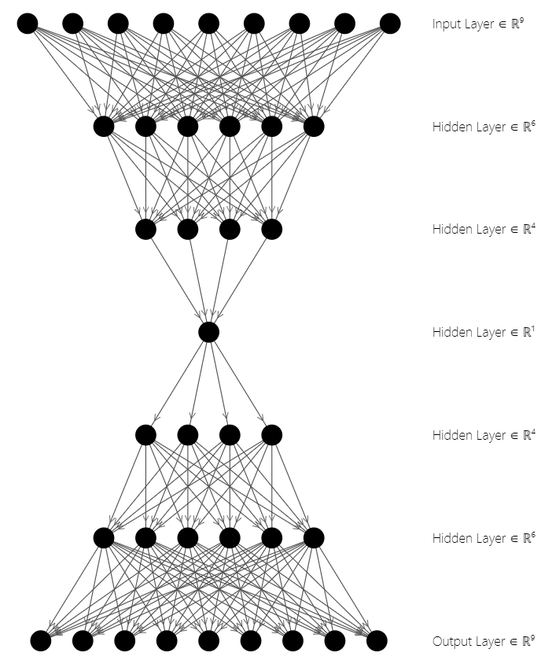

In [29]:
# Create your AutoEncoder network architecture:
def train_autoencoder(latent_space_dim, train_encoder_loader,val_encoder_loader):
    """
    Train an autoencoder neural network based on latent space dimension
    Args:
        latent_space_dim: latent space dimension
        train_encoder_loader: train encoder dataloader
        val_encoder_loader: val encoder dataloader
    """
    model = Autoencoder(latent_space=latent_space_dim)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    print('Model Architecture')
    print(model)

    train_loss, val_loss, train_metric, val_metric,path_autoencoder = train_network(20,train_encoder_loader,val_encoder_loader, model,optimizer, criterion, criterion, autoencoder=True)
    return path_autoencoder

def get_encoder_decoder(space, model_path, loader):
    '''
    Obtain the values of the encoder and the decoder outputs
    Args:
        space: latent space dim
        model_path: saved model path 
        loader: dataloader to the pipeline
    Returns:
        enc_list: list with the encoder output
        decoder_ouput: list with the decoder output
    '''
    #Getting State Dict from trainned model
    model = Autoencoder(latent_space=space).to(device)
    model.load_state_dict(torch.load(model_path))
    enc_list, decoder_output = get_latent_space(model, loader, device)
    print(f'Min Value Encoder: {enc_list.min()}, Max Value: {enc_list.max()}')
    return enc_list, decoder_output

def encoder_to_df_pipeline(space, model_path, loader,size):
    '''
    Pipeline to transform encoder output into a new dataframe
    Some visualization are shown in the process
    Args:
        space: latent space dim
        model_path: saved model path 
        loader: dataloader to the pipeline
    Returns:
        df_encoder: new df with the encoder information
    '''
    enc_list, decoder_output = get_encoder_decoder(space,model_path, loader)
    #Creating dataframe with the decoder output:
    df_decoder = create_new_df(df, decoder_output)

    #Creating a new dataframe with the encoded values
    df_encoder = create_new_df(df, enc_list)
    print('\n')
    print('Visualizing the latent vector of one image and some reconstructions examples')
    plt.imshow(df_encoder.iloc[4, 1:].values.reshape(size, size), cmap='gray')
    plt.title('latent vector')
    ##Seeing some reconstructed images:
    fig, axes = plt.subplots(2, 3,figsize=(12,12), subplot_kw={'xticks':[], 'yticks':[]})
    for i in range(6):
        orig = (df.iloc[i, 1:].values.reshape(28, 28)*255)
    #     encoded = new_df[i, 1:].values.reshape(22, 22)
        decoded = (df_decoder.iloc[i, 1:].values.reshape(28, 28) * 255)
        together = np.concatenate((orig, decoded), axis=1)
        ax = axes.flat[i]
        ax.imshow(together,cmap='gray')
        ax.set_title('original - decoded')
   
    plt.subplots_adjust(wspace=0.02, hspace=-0.6)
    return df_encoder

@torch.no_grad()
def get_latent_space(model, loader, device):
    """
    Performs Dimensitonality Reduction based in a trainned autoencoder model
    Args:
        model: trainned model
        loader: dataloader
        device: gpu or cpu
    Returns:
        enc_list: list of the encoded images
    """
    model.eval()
    enc_list = []
    out_decoder_list = []
    pbar = tqdm(loader)
    
    for img, target in pbar:
        #Setting data to the right device
        img = img.to(device)
        target = target.to(device)
        output = model(img)
        enc = output['enc']
        dec = output['pred']
        
        enc_list.append(enc)
        out_decoder_list.append(dec)
    #tensor dataset, widht 
    enc_list = torch.cat(enc_list).cpu().numpy()
    out_decoder_list = torch.cat(out_decoder_list).cpu().numpy()
    return enc_list, out_decoder_list


#AutoEncoder Dataset Class
class AutoencoderDataset(FashionMinistDataset):
    def __init__(self, df):
        self.df = df
        self.data = list(df.values)
        img = []
        for i in self.data:
            img.append(i[1:])
            
        self.imgs = (np.asarray(img)).astype('float32')  
            
    def __getitem__(self, index):
        img = self.imgs[index]
        img = torch.from_numpy(img).float()
        #(1,28*28)
        return img, img
#Encoder
class Encoder(nn.Module):
    def __init__(self, latente):
        super().__init__()
        self.layer1 = nn.Linear(784, 712)
        self.layer2 = nn.Linear(712, 640)
        self.layer3 = nn.Linear(640, 512)
        self.layer4 = nn.Linear(512, latente)
        
    def forward(self, x):
        #Conv1Layer1                      
        output = F.relu(self.layer1(x))
        #Conv1Layer12                     
        output = F.relu(self.layer2(output))
        #Conv1Layer3                      
        output = F.relu(self.layer3(output))
        #Conv1Layer4                      
        output = self.layer4(output)
       
        return output
#Decoder   
class Decoder(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.layer1 = nn.Linear(latent_space, 512)
        self.layer2 = nn.Linear(512,640 )
        self.layer3 = nn.Linear(640, 712)
        self.layer4 = nn.Linear(712, 784)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
              
        #Conv1Layer1                      
        output = F.relu(self.layer1(x))
        #Conv1Layer12                     
        output = F.relu(self.layer2(output))
        #Conv1Layer3                      
        output = F.relu(self.layer3(output))
        #Conv1Layer4                      
        output = self.layer4(output)
        #Sigmoid
        output = self.sigmoid(output)
        return output

#Decoder   
class Autoencoder(nn.Module):
    def __init__(self, latent_space):
        super().__init__()
        self.encoder = Encoder(latent_space)
        self.decoder = Decoder(latent_space)
        
    def forward(self, x):
        x_encoder = self.encoder(x)
        x_decoder = self.decoder(F.relu(x_encoder))
        
        return {"logit": x_decoder, "pred": x_decoder, "enc": torch.sigmoid(x_encoder)}

In [30]:
# Re-do the first experiment (question 2) considering the autoencoder dimensionality reduction

#Setting Dataset:
train_set_encoder = AutoencoderDataset(train_df)
val_set_encoder = AutoencoderDataset(val_df)

#Setting DataLoaders:
train_encoder_loader = DataLoader(train_set_encoder, shuffle=True, batch_size=64)
val_encoder_loader = DataLoader(val_set_encoder, shuffle=False, batch_size=64)

Model Architecture
Autoencoder(
  (encoder): Encoder(
    (layer1): Linear(in_features=784, out_features=712, bias=True)
    (layer2): Linear(in_features=712, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=512, bias=True)
    (layer4): Linear(in_features=512, out_features=484, bias=True)
  )
  (decoder): Decoder(
    (layer1): Linear(in_features=484, out_features=512, bias=True)
    (layer2): Linear(in_features=512, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=712, bias=True)
    (layer4): Linear(in_features=712, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)


100%|██████████| 188/188 [00:00<00:00, 358.44it/s, Val: Epoch:0, Loss:0.028, Metric: 0.028]


Saving Model ./best_model_epoch_1_metric_0.025.ckpt


100%|██████████| 188/188 [00:00<00:00, 342.22it/s, Val: Epoch:1, Loss:0.022, Metric: 0.022]


Saving Model ./best_model_epoch_2_metric_0.020.ckpt


100%|██████████| 188/188 [00:00<00:00, 340.97it/s, Val: Epoch:2, Loss:0.020, Metric: 0.020]


Saving Model ./best_model_epoch_3_metric_0.019.ckpt


100%|██████████| 188/188 [00:00<00:00, 314.69it/s, Val: Epoch:3, Loss:0.019, Metric: 0.019]


Saving Model ./best_model_epoch_4_metric_0.018.ckpt


100%|██████████| 188/188 [00:00<00:00, 300.25it/s, Val: Epoch:4, Loss:0.018, Metric: 0.018]


Saving Model ./best_model_epoch_5_metric_0.017.ckpt


100%|██████████| 188/188 [00:00<00:00, 330.81it/s, Val: Epoch:5, Loss:0.018, Metric: 0.018]


Saving Model ./best_model_epoch_6_metric_0.016.ckpt


100%|██████████| 188/188 [00:00<00:00, 339.37it/s, Val: Epoch:6, Loss:0.017, Metric: 0.017]


Saving Model ./best_model_epoch_7_metric_0.015.ckpt


100%|██████████| 188/188 [00:00<00:00, 359.60it/s, Val: Epoch:7, Loss:0.016, Metric: 0.016]


Saving Model ./best_model_epoch_8_metric_0.015.ckpt


100%|██████████| 188/188 [00:00<00:00, 356.15it/s, Val: Epoch:8, Loss:0.016, Metric: 0.016]


Saving Model ./best_model_epoch_9_metric_0.014.ckpt


100%|██████████| 188/188 [00:00<00:00, 323.10it/s, Val: Epoch:9, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_10_metric_0.014.ckpt


100%|██████████| 188/188 [00:00<00:00, 367.68it/s, Val: Epoch:10, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_11_metric_0.013.ckpt


100%|██████████| 188/188 [00:00<00:00, 342.54it/s, Val: Epoch:11, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_12_metric_0.013.ckpt


100%|██████████| 188/188 [00:00<00:00, 325.22it/s, Val: Epoch:12, Loss:0.015, Metric: 0.015]


Saving Model ./best_model_epoch_13_metric_0.013.ckpt


100%|██████████| 188/188 [00:00<00:00, 347.27it/s, Val: Epoch:13, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_14_metric_0.013.ckpt


100%|██████████| 188/188 [00:00<00:00, 339.00it/s, Val: Epoch:14, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_15_metric_0.013.ckpt


100%|██████████| 188/188 [00:00<00:00, 326.93it/s, Val: Epoch:15, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_16_metric_0.012.ckpt


100%|██████████| 188/188 [00:00<00:00, 366.87it/s, Val: Epoch:16, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_17_metric_0.012.ckpt


100%|██████████| 188/188 [00:00<00:00, 337.88it/s, Val: Epoch:17, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_18_metric_0.012.ckpt


100%|██████████| 188/188 [00:00<00:00, 324.55it/s, Val: Epoch:18, Loss:0.014, Metric: 0.014]


Saving Model ./best_model_epoch_19_metric_0.012.ckpt


100%|██████████| 188/188 [00:00<00:00, 327.51it/s, Val: Epoch:19, Loss:0.013, Metric: 0.013]


Saving Model ./best_model_epoch_20_metric_0.012.ckpt


100%|██████████| 938/938 [00:00<00:00, 1090.98it/s]


Min Value Encoder: 9.632867295295e-05, Max Value: 0.9989669322967529


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)




Visualizing the latent vector of one image and some reconstructions examples
Model Architecture
ConvNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.1, inplace=False)
  (pool): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


100%|██████████| 188/188 [00:01<00:00, 106.44it/s, Val: Epoch:0, Loss:1.034, Metric: 0.688]


Saving Model ./best_model_epoch_1_metric_0.646.ckpt


100%|██████████| 188/188 [00:01<00:00, 105.62it/s, Val: Epoch:3, Loss:0.711, Metric: 0.812]


Saving Model ./best_model_epoch_4_metric_0.709.ckpt


100%|██████████| 188/188 [00:01<00:00, 106.85it/s, Val: Epoch:4, Loss:0.506, Metric: 0.844]


Saving Model ./best_model_epoch_5_metric_0.732.ckpt


100%|██████████| 188/188 [00:01<00:00, 105.90it/s, Val: Epoch:5, Loss:0.394, Metric: 0.844]


Saving Model ./best_model_epoch_6_metric_0.783.ckpt


100%|██████████| 188/188 [00:01<00:00, 96.77it/s, Val: Epoch:9, Loss:0.800, Metric: 0.719]


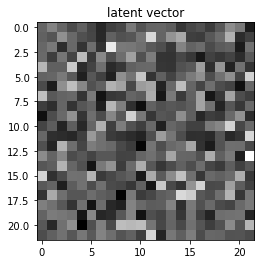

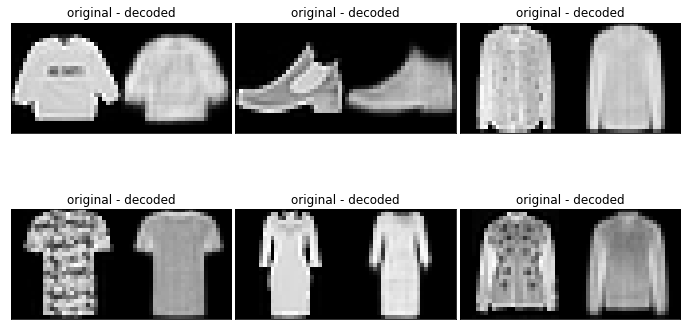

In [31]:

#Getting latent space 22 x 22:
#Train autoencoder
saved_path_484 = train_autoencoder(484, train_encoder_loader,val_encoder_loader)


encoder_set = AutoencoderDataset(df)
encoder_loader = DataLoader(encoder_set, shuffle=False, batch_size=64)
df_encoder_484 = encoder_to_df_pipeline(484,saved_path_484, encoder_loader,22)
model_encoder_484 = retrain_model(df_encoder_484, 22)


In [ ]:
#Getting latent space 22 x 22:
saved_path_256 = train_autoencoder(256, train_encoder_loader,val_encoder_loader)

encoder_set = AutoencoderDataset(df)
encoder_loader = DataLoader(encoder_set, shuffle=False, batch_size=64)
df_encoder_256 = encoder_to_df_pipeline(256,saved_path_256, encoder_loader,16)
model_encoder_256 = retrain_model(df_encoder_256, 16)

Model Architecture
Autoencoder(
  (encoder): Encoder(
    (layer1): Linear(in_features=784, out_features=712, bias=True)
    (layer2): Linear(in_features=712, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=512, bias=True)
    (layer4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (layer1): Linear(in_features=256, out_features=512, bias=True)
    (layer2): Linear(in_features=512, out_features=640, bias=True)
    (layer3): Linear(in_features=640, out_features=712, bias=True)
    (layer4): Linear(in_features=712, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)


100%|██████████| 188/188 [00:00<00:00, 354.64it/s, Val: Epoch:0, Loss:0.025, Metric: 0.025]


Saving Model ./best_model_epoch_1_metric_0.023.ckpt


 73%|███████▎  | 547/750 [00:03<00:01, 179.98it/s, Train: Epoch:1, Loss:0.021, Metric:0.021]

In [ ]:
# What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

## Deadline

Monday, November 18, 11:59 pm. 

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- November 19, 11:59 pm : grade * 0.75
- November 20, 11:59 pm : grade * 0.5
- November 21, 11:59 pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-person group).**